In [1]:
# Imports, paths e seed

import os, json, math, platform, warnings, time
from pathlib import Path
from datetime import datetime
from datetime import timezone
from itertools import product
from typing import List, Dict, Any

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from umap import UMAP
from hdbscan import HDBSCAN
from gensim.models.coherencemodel import CoherenceModel

BASE = Path("../../data")
IN_CSV = BASE/"interim"/"bertopic"/"prep.csv"
OUT_DIR = BASE/"processed"/"bertopic"
FIGS = Path("../../reports/figs")

OUT_DIR.mkdir(parents=True, exist_ok=True)
FIGS.mkdir(parents=True, exist_ok=True)

SEED = 42
np.random.seed(SEED)

def _get_ver(pkg):
    try:
        import importlib.metadata as im
        return im.version(pkg)
    except Exception:
        return "NA"

versions = {
    "python": platform.python_version(),
    "bertopic": _get_ver("bertopic"),
    "sentence-transformers": _get_ver("sentence-transformers"),
    "umap-learn": _get_ver("umap-learn"),
    "hdbscan": _get_ver("hdbscan"),
    "scikit-learn": _get_ver("scikit-learn"),
    "gensim": _get_ver("gensim"),
    "numpy": _get_ver("numpy"),
    "pandas": _get_ver("pandas")
}
print("VERSIONS:", json.dumps(versions, indent=2, ensure_ascii=False))

VERSIONS: {
  "python": "3.12.2",
  "bertopic": "0.16.0",
  "sentence-transformers": "2.6.1",
  "umap-learn": "0.5.6",
  "hdbscan": "0.8.33",
  "scikit-learn": "1.4.2",
  "gensim": "4.3.3",
  "numpy": "1.26.4",
  "pandas": "2.2.2"
}


In [2]:
# Stopwords em português (para CountVectorizer)
try:
    from nltk.corpus import stopwords as nltk_stop
    STOP_WORDS_PT = sorted(set(nltk_stop.words('portuguese')))
    print(f"STOP_WORDS_PT carregadas: {len(STOP_WORDS_PT)} termos")
except Exception as e:
    # fallback mínimo para não travar caso NLTK falhe (mantém pipeline funcionando)
    print("[WARN] NLTK indisponível; usando fallback reduzido:", e)
    STOP_WORDS_PT = sorted(set("""
a à acerca agora ai ainda além algo alguem alguns algumas algum alguma ambos ambas ante antes ao aos após aquela aquelas aquele aqueles aquilo as assim até através cada quase com como contra contudo cujo cuja cujos cujas da das de dela delas dele deles depois desde desta deste disso disto do dos e é ela elas ele eles em entre era eram essa essas esse esses esta estas este estes estou eu foi foram fosse fossem fui há isso isto já la lá lhe lhes mais mas me mesmo mesmoa mesmos mesmas minha minhas meu meus muito muita muitas muitos não na nas nem no nos nós o os ou para pela pelas pelo pelos pouca poucas pouco poucos por porque porém pra qual quais quando que quem se sem sempre sendo ser seu seus sob sobre sua suas também tão tão tem tenho ter teu teus tua tuas tudo um uma umas uns
""".split()))

STOP_WORDS_PT carregadas: 207 termos


In [3]:
# Leitura e preparação dos textos

df = pd.read_csv(IN_CSV, encoding="utf-8")

required_cols = {"DOC_ID", "resumo", "RESUMO_PREP_BERTOPIC"}
missing = required_cols - set(df.columns)
assert not missing, f"Colunas ausentes: {missing}"

docs_for_embeddings = (
    df["resumo"].fillna(df["RESUMO_PREP_BERTOPIC"]).astype(str).tolist()
)
docs_for_vectorizer = (
    df["RESUMO_PREP_BERTOPIC"].fillna("").astype(str).tolist()
)

lens = pd.Series([len(x) for x in docs_for_vectorizer])
print("N documentos:", len(df))
print("Docs vazios (vectorizer):", sum([len(x.strip()) == 0 for x in docs_for_vectorizer]))
print("Comprimento (chars) — quantis:", lens.quantile([0.0, 0.25, 0.5, 0.75, 0.95, 1.0]).to_dict())


N documentos: 423
Docs vazios (vectorizer): 14
Comprimento (chars) — quantis: {0.0: 0.0, 0.25: 894.5, 0.5: 1123.0, 0.75: 1322.5, 0.95: 1729.2999999999997, 1.0: 2309.0}


In [4]:
# Embeddings (SBERT)

# Modelo multilíngue leve que preserva semântica de sentenças (SBERT)
# BERT → base dos embeddings contextuais [Devlin et al.] usados em SBERT
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
sbert_name = "paraphrase-multilingual-MiniLM-L12-v2"

start = time.time()
sbert = SentenceTransformer(sbert_name, device=device)
embeddings = sbert.encode(
    docs_for_embeddings,
    batch_size=64,
    show_progress_bar=True,
    normalize_embeddings=True,
    convert_to_numpy=True
)
elapsed = time.time() - start
print(f"Embeddings shape={embeddings.shape} | device={device} | time={elapsed:.1f}s")


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Embeddings shape=(423, 384) | device=cpu | time=11.9s


In [5]:
# Grade de hiperparâmetros (mini-sweep)

from math import floor
N_DOCS = len(docs_for_vectorizer)

# --- grade atualizada ---
grid_umap = {
    "n_neighbors": [10, 15, 30],
    "n_components": [5],
    "min_dist": [0.0],
    "metric": ["cosine"],
    "random_state": [SEED],
}
grid_hdb = {
    "min_cluster_size": [10, 15, 20],
    "min_samples": [None],
    "metric": ["euclidean"],
    "cluster_selection_method": ["eom"],
    "prediction_data": [True],
}
# >>> use a lista STOP_WORDS_PT (construída no Bloco 1B via NLTK ou spaCy)
grid_vec = {
    "ngram_range": [(1,1), (1,2)],
    "stop_words": [STOP_WORDS_PT],   # <<< nunca string "portuguese"
    "min_df": [2, 3],
    "max_df": [0.9],                 # vamos filtrar combos inválidos logo abaixo
}

# Produto cartesiano
from itertools import product
combos_all = []
for u, h, v in product(
    product(*grid_umap.values()),
    product(*grid_hdb.values()),
    product(*grid_vec.values())
):
    umap_kwargs = dict(zip(grid_umap.keys(), u))
    hdb_kwargs = dict(zip(grid_hdb.keys(), h))
    vec_kwargs = dict(zip(grid_vec.keys(), v))
    combos_all.append({"umap": umap_kwargs, "hdb": hdb_kwargs, "vec": vec_kwargs})

# Baseline com stopwords corretas
baseline = {
    "umap": {"n_neighbors": 15, "n_components": 5, "min_dist": 0.0, "metric": "cosine", "random_state": SEED},
    "hdb": {"min_cluster_size": 15, "min_samples": None, "metric": "euclidean",
            "cluster_selection_method": "eom", "prediction_data": True},
    "vec": {"ngram_range": (1,2), "stop_words": STOP_WORDS_PT, "min_df": 3, "max_df": 0.9},
}

# Move baseline para o início (sem duplicar)
def _same(a, b): return json.dumps(a, sort_keys=True) == json.dumps(b, sort_keys=True)
combos = [baseline] + [c for c in combos_all if not _same(c, baseline)]

# ---- filtro para evitar o erro "max_df corresponds to < documents than min_df"
def _valid_vec(v, n_docs: int) -> bool:
    min_df = v["min_df"]
    max_df = v["max_df"]
    # max_df como proporção → #docs máximos admitidos
    max_docs = floor(max_df * n_docs) if isinstance(max_df, float) else int(max_df)
    return max_docs >= int(min_df)

combos = [c for c in combos if _valid_vec(c["vec"], N_DOCS)]

# Opcional: limitar a 18 amostras determinísticas, mantendo baseline na frente
rng = np.random.RandomState(SEED)
if len(combos) > 18:
    # preserva baseline + 17 amostras
    others = combos[1:]
    idx = rng.choice(len(others), size=17, replace=False)
    combos = [combos[0]] + [others[i] for i in sorted(idx)]

print(f"Combos válidos após filtro: {len(combos)}")
print("Baseline stop_words tipo:", type(combos[0]['vec']['stop_words']).__name__,
      "| tamanho:", len(combos[0]['vec']['stop_words']) if hasattr(combos[0]['vec']['stop_words'], '__len__') else 'NA')

Combos válidos após filtro: 18
Baseline stop_words tipo: list | tamanho: 207


In [6]:
# Funções auxiliares

def write_json(path: Path, data: Dict[str, Any]):
    path.parent.mkdir(parents=True, exist_ok=True)
    with open(path, "w", encoding="utf-8") as f:
        json.dump(data, f, indent=2, ensure_ascii=False)

def extract_topic_words(topic_model: BERTopic, topk: int = 10) -> List[List[str]]:
    topics_dict = topic_model.get_topics()
    topic_words: List[List[str]] = []
    for tid, pairs in topics_dict.items():
        if tid == -1:
            continue
        # BERTopic pode retornar None/[] para tópicos degenerados
        if not pairs:
            continue
        # Garante apenas strings não vazias; respeita topk
        toks = [str(w).strip() for (w, _) in pairs[:topk] if isinstance(w, (str, bytes)) and str(w).strip()]
        if toks:
            topic_words.append(toks)
    return topic_words

def simple_tokenize_docs(docs: List[str]) -> List[List[str]]:
    # Tokenização simples coerente com o CountVectorizer (lower/space)
    return [str(d).lower().split() for d in docs]

def topic_diversity(topic_words: List[List[str]], topk: int = 10) -> float:
    if not topic_words:
        return float("nan")
    uniq = len(set([w for tw in topic_words for w in tw[:topk]]))
    return uniq / (topk * len(topic_words))

def outlier_rate(topics: List[int]) -> float:
    topics = np.array(topics)
    return float(np.mean(topics == -1))

def _sanitize_topics_for_gensim(topic_words: List[List[str]]) -> List[List[str]]:
    clean: List[List[str]] = []
    for tw in topic_words:
        if not isinstance(tw, (list, tuple)):
            continue
        toks = [str(t).strip() for t in tw if isinstance(t, (str, bytes)) and str(t).strip()]
        if toks:
            clean.append(toks)
    return clean

def compute_coherences(topic_words, tokenized_docs):
    # c_npmi e c_uci com 'texts' (ambas aceitam texts); sanear antes de passar ao gensim
    from gensim.corpora import Dictionary
    from gensim.models.coherencemodel import CoherenceModel

    cleaned = _sanitize_topics_for_gensim(topic_words)
    if not cleaned:
        return float("nan"), float("nan")

    dictionary = Dictionary(tokenized_docs)

    c_npmi = CoherenceModel(
        topics=cleaned, texts=tokenized_docs, dictionary=dictionary, coherence="c_npmi"
    ).get_coherence()

    c_uci = CoherenceModel(
        topics=cleaned, texts=tokenized_docs, dictionary=dictionary, coherence="c_uci"
    ).get_coherence()

    return float(c_npmi), float(c_uci)

In [7]:
 # Loop do sweep: treino, avaliação e salvamento por trial

tokenized_docs = simple_tokenize_docs(docs_for_vectorizer)
trials_summary = []
errors_log = []

N_DOCS_EFF = len(docs_for_vectorizer)  # usado para sanear min_df/max_df

for i, cfg in enumerate(tqdm(combos, desc="Sweep")):
    trial_id = f"trial_{i:02d}"
    tdir = OUT_DIR / trial_id
    tdir.mkdir(parents=True, exist_ok=True)

    # --- SANEAMENTO do Vectorizer (evita "max_df corresponds to < documents than min_df" e 'portuguese')
    vec_kwargs = cfg["vec"].copy()
    sw = vec_kwargs.get("stop_words", None)
    if isinstance(sw, str):
        vec_kwargs["stop_words"] = STOP_WORDS_PT

    min_df = vec_kwargs.get("min_df", 1)
    max_df = vec_kwargs.get("max_df", 1.0)
    min_df_prop = (min_df / max(N_DOCS_EFF, 1)) if isinstance(min_df, int) else float(min_df)
    max_df_prop = (max_df / max(N_DOCS_EFF, 1)) if isinstance(max_df, int) else float(max_df)
    if max_df_prop < min_df_prop:
        max_df_prop = min(1.0, max(min_df_prop + 1e-9, 0.999))
    vec_kwargs["min_df"] = min_df_prop
    vec_kwargs["max_df"] = max_df_prop

    # Instâncias dos componentes
    vectorizer_model = CountVectorizer(**vec_kwargs)
    umap_model = UMAP(**cfg["umap"])
    hdbscan_model = HDBSCAN(**cfg["hdb"])

    topic_model = BERTopic(
        embedding_model=None,
        vectorizer_model=vectorizer_model,
        umap_model=umap_model,
        hdbscan_model=hdbscan_model,
        calculate_probabilities=True,
        verbose=False
    )

    started = datetime.now(timezone.utc).isoformat()
    t0 = time.time()
    try:
        topics, probs = topic_model.fit_transform(
            documents=docs_for_vectorizer,
            embeddings=embeddings
        )
        fit_time = time.time() - t0

        # Artefatos primários
        topic_info = topic_model.get_topic_info()
        topic_info.to_csv(tdir/"topic_info.csv", index=False, encoding="utf-8")

        # Doc→tópico
        if probs is not None and hasattr(probs, "__array__"):
            rowmax = np.nanmax(probs, axis=1)
            doc_prob = [float(x) if np.isfinite(x) else np.nan for x in rowmax]
        else:
            doc_prob = [np.nan] * len(topics)

        doc_topics = pd.DataFrame({
            "DOC_ID": df["DOC_ID"].values,
            "topic": topics,
            "prob": doc_prob
        })
        doc_topics.to_csv(tdir/"doc_topics.csv", index=False, encoding="utf-8")

        ctf = topic_model.c_tf_idf_
        arr = ctf.toarray() if hasattr(ctf, "toarray") else np.asarray(ctf)
        np.save(tdir/"c_tf_idf.npy", arr)

        vocab = vectorizer_model.get_feature_names_out()
        with open(tdir/"vocab.txt", "w", encoding="utf-8") as f:
            f.write("\n".join(map(str, vocab)))


        # Métricas (com blindagem de coerência)
        topic_words = extract_topic_words(topic_model, topk=10)
        div = topic_diversity(topic_words, topk=10)
        try:
            c_npmi, c_uci = compute_coherences(topic_words, tokenized_docs)
        except Exception as ce:
            c_npmi, c_uci = float("nan"), float("nan")
            write_json(tdir/"coherence_error.json", {"error": repr(ce)})

        out_rate = outlier_rate(topics)

        metrics = {
            "topic_diversity@10": div,
            "c_npmi": c_npmi,
            "c_uci": c_uci,
            "outlier_rate": out_rate,
            "n_topics_excl_-1": int((topic_info["Topic"] != -1).sum()),
            "fit_time_sec": fit_time
        }
        write_json(tdir/"metrics.json", metrics)

        # Metadados de execução
        run_md = {
            "trial_id": trial_id,
            "started_utc": started,
            "finished_utc": datetime.now(timezone.utc).isoformat(),
            "seed": SEED,
            "versions": versions,
            "paths": {
                "input_csv": str(IN_CSV.resolve()),
                "trial_dir": str(tdir.resolve())
            },
            "params": {
                "umap": cfg["umap"],
                "hdbscan": cfg["hdb"],
                "vectorizer": {
                    **{k: (list(v) if k=="ngram_range" else v) for k, v in cfg["vec"].items()},
                    "_effective_min_df": vec_kwargs["min_df"],
                    "_effective_max_df": vec_kwargs["max_df"],
                },
                "sbert_model": sbert_name,
            },
            "sizes": {
                "n_docs": len(df),
                "emb_dim": int(embeddings.shape[1])
            }
        }
        write_json(tdir/"run_metadata.json", run_md)

        trials_summary.append({
            "trial_id": trial_id,
            "metrics": metrics,
            "cfg": cfg
        })

    except Exception as e:
        err = {"trial_id": trial_id, "error": repr(e)}
        errors_log.append(err)
        write_json(tdir/"error.json", err)
        print(f"[WARN] {trial_id} falhou: {e}")

Sweep:   0%|          | 0/18 [00:00<?, ?it/s]

In [21]:
# === UMAP + HDBSCAN (com outliers) -> PNG (robusto à sua versão do BERTopic) ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# 0) Descobre raiz do projeto (data/ e reports/ no mesmo nível de notebooks/)
def find_proj_root(start: Path) -> Path:
    cands = [start, start.parent, start.parent.parent]
    for c in cands:
        if (c/"data").exists() and (c/"reports").exists():
            return c
    return start

NB_CWD    = Path.cwd().resolve()
PROJ_ROOT = find_proj_root(NB_CWD)
OUT_FG    = PROJ_ROOT / "reports" / "figures"
OUT_FG.mkdir(parents=True, exist_ok=True)
PNG_PATH  = OUT_FG / "fig8_bertopic_umap_clusters.png"

# 1) Sanidade: precisa de topic_model e docs em memória
assert "topic_model" in globals(), "topic_model não está em memória. Rode o fit_transform antes."
assert "docs" in globals(), "A lista 'docs' não está em memória. Carregue/defina os documentos usados no fit."

# 2) Embeddings de documento (usando o próprio BERTopic)
#    Preferência: método interno _extract_embeddings; fallback: embedding_model.embed_documents
try:
    doc_embs = topic_model._extract_embeddings(docs, method="document")
except Exception:
    emb_model = getattr(topic_model, "embedding_model", None)
    assert emb_model is not None, "embedding_model indisponível; não foi possível extrair embeddings."
    # muitos wrappers do BERTopic expõem .embed_documents
    if hasattr(emb_model, "embed_documents"):
        doc_embs = emb_model.embed_documents(docs)
    else:
        raise RuntimeError("Não consegui extrair embeddings: nem _extract_embeddings nem embed_documents estão disponíveis.")

doc_embs = np.asarray(doc_embs)
assert doc_embs.ndim == 2, f"Embeddings com forma inesperada: {doc_embs.shape}"

# 3) Parâmetros do UMAP (2D) derivados do modelo (se existir), senão defaults razoáveis
try:
    umap_cfg = getattr(topic_model, "umap_model", None)
    from umap import UMAP
    umap_kwargs = dict(
        n_neighbors = getattr(umap_cfg, "n_neighbors", 15) if umap_cfg else 15,
        min_dist    = getattr(umap_cfg, "min_dist", 0.0)   if umap_cfg else 0.0,
        metric      = getattr(umap_cfg, "metric", "cosine") if umap_cfg else "cosine",
        random_state= getattr(umap_cfg, "random_state", 42) if umap_cfg else 42,
        n_components= 2
    )
    umap2d = UMAP(**umap_kwargs).fit_transform(doc_embs)
except Exception as e:
    raise RuntimeError(f"Falha ao projetar UMAP 2D: {e}")

# 4) Rótulos por documento (clusters)
#    a) se 'topics' está em memória, usa; b) tenta get_document_info(docs); c) fallback: doc_topics.csv do trial_00
if "topics" in globals():
    labels = np.asarray(topics)
else:
    try:
        df_info = topic_model.get_document_info(docs)
        col = "Topic" if "Topic" in df_info.columns else ("topic" if "topic" in df_info.columns else None)
        assert col is not None, "DataFrame de info não contém coluna Topic/topic."
        labels = df_info[col].to_numpy()
    except Exception:
        trial_dir = PROJ_ROOT / "data" / "processed" / "bertopic" / "trial_00"  # ajuste se necessário
        doclab_p = trial_dir / "doc_topics.csv"
        assert doclab_p.exists(), f"Fallback: {doclab_p} não encontrado."
        labels = pd.read_csv(doclab_p)["topic"].to_numpy()

labels = np.asarray(labels)
assert len(labels) == umap2d.shape[0], f"labels ({len(labels)}) ≠ umap2d ({umap2d.shape[0]}) — verifique a ordem/quantidade de docs."

# 5) Métricas rápidas para o título
is_out    = (labels == -1)
out_pct   = float(is_out.mean()) * 100.0
k_clusters= int(len(set(labels)) - (1 if -1 in labels else 0))

# 6) Plot (Matplotlib): outliers em cinza, clusters coloridos
plt.figure(figsize=(10.5, 7.5))

# Outliers por baixo
if is_out.any():
    plt.scatter(umap2d[is_out, 0], umap2d[is_out, 1],
                s=8, c="#c0c0c0", alpha=0.55, linewidths=0, label="outliers (-1)")

# Clusters
unique_clusters = sorted([c for c in np.unique(labels) if c != -1])
max_legend = 20  # evita poluição da legenda
for i, c in enumerate(unique_clusters):
    mask = (labels == c)
    plt.scatter(umap2d[mask, 0], umap2d[mask, 1],
                s=12, alpha=0.85, linewidths=0, label=(f"T{c}" if i < max_legend else None))

plt.title(f"UMAP + HDBSCAN — clusters e outliers (K={k_clusters}, outliers={out_pct:.1f}%)")
plt.xlabel("UMAP-1"); plt.ylabel("UMAP-2")

handles, labels_leg = plt.gca().get_legend_handles_labels()
if handles:
    plt.legend(ncol=3, fontsize=8, frameon=False)

plt.tight_layout()
plt.savefig(PNG_PATH, dpi=220)
plt.show()
print("PNG salvo em:", PNG_PATH)


AssertionError: A lista 'docs' não está em memória. Carregue/defina os documentos usados no fit.

In [8]:
# Exporta a tabela da varredura de trials (trials_summary.csv) — robusta com raiz do projeto
import pandas as pd, os
from pathlib import Path

# 1) Descobre a raiz do projeto (procura por uma pasta 'data' subindo diretórios)
def find_repo_root(start: Path = None, max_hops: int = 8) -> Path:
    p = start or Path.cwd()
    for _ in range(max_hops + 1):
        if (p / "data").is_dir():
            return p
        if p.parent == p:
            break
        p = p.parent
    # fallback: diretório atual
    return Path.cwd()

ROOT = find_repo_root()
OUT_DIR = ROOT / "data" / "processed" / "bertopic"
OUT_DIR.mkdir(parents=True, exist_ok=True)

assert 'trials_summary' in globals() and len(trials_summary) > 0, "trials_summary vazio. Rode o sweep antes."

def row_from_trial(t):
    m   = t.get('metrics', {})
    cfg = t.get('cfg', {})
    um  = cfg.get('umap', {})
    hb  = cfg.get('hdb', {})
    vc  = cfg.get('vec', {})
    return {
        'trial_id': t.get('trial_id'),
        'n_docs': t.get('n_docs', None),
        'n_topics_excl_minus1': m.get('n_topics_excl_-1', None),
        'outlier_rate': m.get('outlier_rate', None),
        'c_npmi': m.get('c_npmi', None),
        'c_v': m.get('c_v', None),
        'topic_diversity_at_10': m.get('topic_diversity@10', None),
        'sep_jsd': m.get('sep_jsd', None),
        'balance': m.get('balance', None),
        'clarity': m.get('clarity', None),
        'umap_n_neighbors': um.get('n_neighbors'),
        'umap_n_components': um.get('n_components'),
        'umap_min_dist': um.get('min_dist'),
        'umap_metric': um.get('metric'),
        'hdbscan_min_cluster_size': hb.get('min_cluster_size'),
        'hdbscan_min_samples': hb.get('min_samples'),
        'hdbscan_metric': hb.get('metric'),
        'hdbscan_selection': hb.get('cluster_selection_method'),
        'vectorizer_min_df': vc.get('min_df'),
        'vectorizer_max_df': vc.get('max_df'),
        'vectorizer_ngram': str(vc.get('ngram_range')),
        'embedding_model': cfg.get('sbert_model')
    }

df = pd.DataFrame([row_from_trial(t) for t in trials_summary])

out = OUT_DIR / "trials_summary.csv"
df.to_csv(out, index=False, encoding="utf-8")

print("Salvo em (absoluto):", out.resolve())
print("Linhas:", len(df), "| Colunas:", len(df.columns))
print("\nArquivos no diretório de saída:")
for f in sorted(OUT_DIR.iterdir()):
    print(" -", f.name)

display(df.head(5))

Salvo em (absoluto): C:\Users\User\Desktop\TCC\Notebooks locais\analise_topicos_tcc\notebooks\bertopic\data\processed\bertopic\trials_summary.csv
Linhas: 18 | Colunas: 22

Arquivos no diretório de saída:
 - trials_summary.csv


,trial_id,n_docs,n_topics_excl_minus1,outlier_rate,c_npmi,c_v,topic_diversity_at_10,sep_jsd,balance,clarity,...,umap_min_dist,umap_metric,hdbscan_min_cluster_size,hdbscan_min_samples,hdbscan_metric,hdbscan_selection,vectorizer_min_df,vectorizer_max_df,vectorizer_ngram,embedding_model
0,trial_00,None,4,0.446809,-0.280830,None,0.975000,None,None,None,...,0.0,cosine,15,None,euclidean,eom,3,0.9,"(1, 2)",None
1,trial_01,None,2,0.000000,-0.054650,None,1.000000,None,None,None,...,0.0,cosine,10,None,euclidean,eom,2,0.9,"(1, 1)",None
2,trial_02,None,5,0.456265,-0.298389,None,0.980000,None,None,None,...,0.0,cosine,15,None,euclidean,eom,2,0.9,"(1, 1)",None
3,trial_03,None,6,0.527187,-0.246302,None,0.983333,None,None,None,...,0.0,cosine,15,None,euclidean,eom,3,0.9,"(1, 1)",None
4,trial_04,None,4,0.550827,-0.263085,None,0.975000,None,None,None,...,0.0,cosine,20,None,euclidean,eom,2,0.9,"(1, 1)",None


ART_DIR: C:\Users\User\Desktop\TCC\Notebooks locais\analise_topicos_tcc\data\processed\bertopic\trial_00
CSV reprodutível -> C:\Users\User\Desktop\TCC\Notebooks locais\analise_topicos_tcc\reports\tables\tabela3_bertopic_oficial.csv


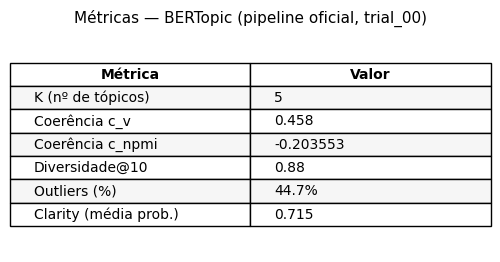

IMAGEM salva -> C:\Users\User\Desktop\TCC\Notebooks locais\analise_topicos_tcc\reports\figures\tabela3_bertopic_oficial.png


In [17]:
# === Tabela 3 (oficial, trial_00) — calcula métricas e salva IMAGEM (PNG) ===
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel

# 0) Raiz do projeto (ajuste se necessário)
PROJ_ROOT = Path(r"C:\Users\User\Desktop\TCC\Notebooks locais\analise_topicos_tcc")

# 1) Trial vencedor (oficial)
ART_DIR = PROJ_ROOT / "data" / "processed" / "bertopic" / "trial_00"
print("ART_DIR:", ART_DIR)

# 2) Arquivos obrigatórios
ctf_np   = ART_DIR / "c_tf_idf.npy"
ctf_sp   = ART_DIR / "c_tf_idf.npz"
vocab_p  = ART_DIR / "vocab.txt"
doclab_p = ART_DIR / "doc_topics.csv"
topicinfo_p = ART_DIR / "topic_info.csv"
assert any([ctf_np.exists(), ctf_sp.exists()]), "c_tf_idf.(npy|npz) não encontrado em trial_00"
assert vocab_p.exists(), "vocab.txt não encontrado em trial_00"
assert doclab_p.exists(), "doc_topics.csv não encontrado em trial_00"
assert topicinfo_p.exists(), "topic_info.csv não encontrado em trial_00"

# 3) Carregamentos
if ctf_np.exists():
    C = np.load(ctf_np)                  # (K x |V|)
else:
    from scipy.sparse import load_npz
    C = load_npz(ctf_sp).toarray()

vocab = [ln.strip() for ln in open(vocab_p, encoding="utf-8")]
assert C.shape[1] == len(vocab), f"C ({C.shape}) ≠ len(vocab) ({len(vocab)})"

TOPN = 10
topics_terms = []
for r in range(C.shape[0]):
    row = C[r]
    if row.size == 0 or not np.isfinite(row).any():
        topics_terms.append([])
        continue
    idx = np.argpartition(row, -TOPN)[-TOPN:]
    idx = idx[np.argsort(row[idx])[::-1]]
    topics_terms.append([vocab[i] for i in idx])

# 4) Métricas
def topic_diversity(top_terms, topn:int) -> float:
    if not top_terms or not top_terms[0]:
        return float("nan")
    uniq = len(set(sum(top_terms, [])))
    return float(uniq / (len(top_terms) * topn))

div10 = topic_diversity(topics_terms, TOPN)

REF_TEXTS = PROJ_ROOT / "data" / "interim" / "lda" / "ref_corpus_tokens.txt"
assert REF_TEXTS.exists(), f"ref_corpus_tokens.txt não encontrado: {REF_TEXTS}"
ref_texts = [ln.strip().split() for ln in REF_TEXTS.read_text(encoding="utf-8").splitlines()]
ref_dict  = Dictionary(ref_texts)

c_v    = float(CoherenceModel(topics=topics_terms, texts=ref_texts, dictionary=ref_dict, coherence="c_v").get_coherence())
c_npmi = float(CoherenceModel(topics=topics_terms, texts=ref_texts, dictionary=ref_dict, coherence="c_npmi").get_coherence())

df_lab = pd.read_csv(doclab_p)
assert "topic" in df_lab.columns, "doc_topics.csv precisa de coluna 'topic'"
topics_arr   = df_lab["topic"].to_numpy()
outliers_pct = float((topics_arr == -1).mean())
clarity      = float(1.0 - outliers_pct)
if "prob" in df_lab.columns:
    try:
        clarity = float(np.nanmean(df_lab.loc[df_lab["topic"]!=-1, "prob"]))
    except Exception:
        pass

K = int(C.shape[0])

# 5) (Opcional) exporta CSV reprodutível
OUT_TB = PROJ_ROOT / "reports" / "tables"
OUT_TB.mkdir(parents=True, exist_ok=True)
df_out = pd.DataFrame([{
    "method": "bertopic",
    "scenario": "oficial",
    "trial_dir": str(ART_DIR),
    "K": K,
    "c_v": c_v,
    "c_npmi": c_npmi,
    "topic_diversity@10": div10,
    "outliers_pct": outliers_pct,
    "clarity": clarity,
}])
out_csv = OUT_TB / "tabela3_bertopic_oficial.csv"
df_out.to_csv(out_csv, index=False, encoding="utf-8")
print("CSV reprodutível ->", out_csv)

# 6) Renderiza Tabela 3 como IMAGEM (PNG, 300 dpi)
OUT_FG = PROJ_ROOT / "reports" / "figures"
OUT_FG.mkdir(parents=True, exist_ok=True)

# prepara pares (Métrica, Valor formatado)
rows = [
    ("K (nº de tópicos)",      f"{K:d}"),
    ("Coerência c_v",          f"{c_v:.3f}"),
    ("Coerência c_npmi",       f"{c_npmi:.6f}"),
    ("Diversidade@10",         f"{div10:.2f}"),
    ("Outliers (%)",           f"{outliers_pct*100:.1f}%"),
    ("Clarity (média prob.)",  f"{clarity:.3f}"),
]

fig, ax = plt.subplots(figsize=(6.2, 2.8))  # ajuste fino de tamanho
ax.axis('off')

# desenha tabela simples 2 colunas
table = ax.table(
    cellText=rows,
    colLabels=["Métrica", "Valor"],
    loc='center',
    cellLoc='left',
)
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.4)  # altura das linhas

# estilo: cabeçalho em negrito
for (row, col), cell in table.get_celld().items():
    if row == 0:
        cell.set_text_props(weight='bold')
    # listras suaves alternadas (zebra)
    if row > 0 and row % 2 == 1:
        cell.set_facecolor("#f6f6f6")

# título opcional (sem “Figura/Tabela” para você rotular no LaTeX/Word)
ax.set_title("Métricas — BERTopic (pipeline oficial, trial_00)", pad=10, fontsize=11)

png_path = OUT_FG / "tabela3_bertopic_oficial.png"
plt.savefig(png_path, dpi=300, bbox_inches="tight")
plt.show()
print("IMAGEM salva ->", png_path)


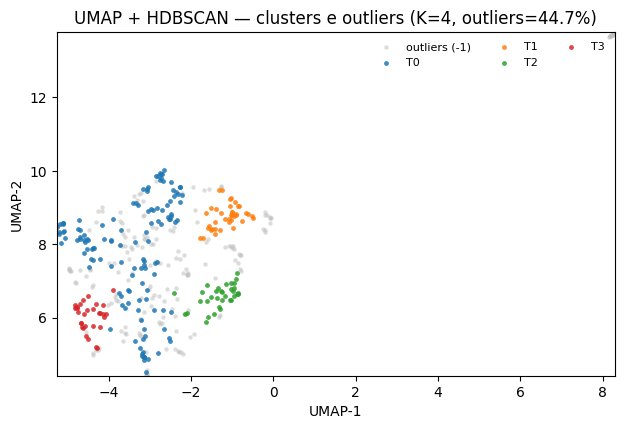

PNG salvo em: C:\Users\User\Desktop\TCC\Notebooks locais\analise_topicos_tcc\reports\figures\fig8_umap_two_col.png


In [ ]:
# === UMAP + HDBSCAN (trial_00) -> PNG (sem precisar de 'docs' em memória) ===
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# 0) Raiz do projeto e caminhos do trial vencedor (oficial)
PROJ_ROOT = Path(r"C:\Users\User\Desktop\TCC\Notebooks locais\analise_topicos_tcc")
TRIAL_DIR = PROJ_ROOT / "data" / "processed" / "bertopic" / "trial_00"
DOC_TOPICS_CSV = TRIAL_DIR / "doc_topics.csv"
RUN_META_JSON  = TRIAL_DIR / "run_metadata.json"
TOPIC_INFO_CSV = TRIAL_DIR / "topic_info.csv"

assert DOC_TOPICS_CSV.exists(), f"doc_topics.csv não encontrado: {DOC_TOPICS_CSV}"
assert RUN_META_JSON.exists(),  f"run_metadata.json não encontrado: {RUN_META_JSON}"
assert TOPIC_INFO_CSV.exists(), f"topic_info.csv não encontrado: {TOPIC_INFO_CSV}"
assert "embeddings" in globals(), (
    "A variável 'embeddings' não está em memória. Recarregue/compute antes desta célula."
)

# 1) Carrega rótulos e hiperparâmetros do UMAP do trial_00
df_lab = pd.read_csv(DOC_TOPICS_CSV)
assert "topic" in df_lab.columns, "doc_topics.csv precisa conter a coluna 'topic'."
labels = df_lab["topic"].to_numpy()

meta = json.loads(RUN_META_JSON.read_text(encoding="utf-8"))
umap_cfg = meta.get("params", {}).get("umap", {})  # dict salvo no treino

# 2) K consistente com a rotulação (ignora -1 e Count=0)
info_df = pd.read_csv(TOPIC_INFO_CSV)
K_effective = int(info_df.query("Topic != -1 & Count > 0").shape[0])

# 3) Garante compatibilidade de tamanhos
emb = np.asarray(embeddings)
assert emb.shape[0] == len(labels), (
    f"embeddings ({emb.shape[0]}) ≠ nº de rótulos ({len(labels)}). "
    "Garanta que são do mesmo corpus/ordem do trial_00."
)

# 4) Projeta para 2D com os MESMOS hiperparâmetros do trial (força n_components=2)
from umap import UMAP
umap2d = UMAP(
    n_neighbors = int(umap_cfg.get("n_neighbors", 15)),
    min_dist    = float(umap_cfg.get("min_dist", 0.0)),
    metric      = umap_cfg.get("metric", "cosine"),
    random_state= int(umap_cfg.get("random_state", 42)),
    n_components= 2
).fit_transform(emb)

# 5) Plot (redimensionado, sem zoom) e salvamento
OUT_FG = PROJ_ROOT / "reports" / "figures"
OUT_FG.mkdir(parents=True, exist_ok=True)

TARGET = "two_col"   # "one_col" | "one_and_half" | "two_col"
DPI    = 400
width_in = {"one_col": 3.46, "one_and_half": 5.20, "two_col": 7.20}[TARGET]
ratio = 0.62
ms_cluster = {"one_col": 8, "one_and_half": 10, "two_col": 12}[TARGET]
ms_outlier = max(6, ms_cluster - 2)

fig, ax = plt.subplots(figsize=(width_in, width_in*ratio))

is_out = (labels == -1)
out_pct = float(is_out.mean()) * 100.0

# outliers por baixo
if is_out.any():
    ax.scatter(umap2d[is_out, 0], umap2d[is_out, 1],
               s=ms_outlier, c="#c0c0c0", alpha=0.55, linewidths=0, label="outliers (-1)")

# clusters coloridos
unique_clusters = sorted([c for c in np.unique(labels) if c != -1])
max_legend = 20
for i, c in enumerate(unique_clusters):
    m = (labels == c)
    ax.scatter(umap2d[m, 0], umap2d[m, 1],
               s=ms_cluster, alpha=0.85, linewidths=0, label=(f"T{c}" if i < max_legend else None))

ax.set_title(f"UMAP + HDBSCAN — clusters e outliers (K={K_effective}, outliers={out_pct:.1f}%)")
ax.set_xlabel("UMAP-1"); ax.set_ylabel("UMAP-2")
handles, labels_leg = ax.get_legend_handles_labels()
if handles:
    ax.legend(ncol=3, fontsize=8, frameon=False)

ax.margins(0)
PNG_PATH = OUT_FG / f"fig8_umap_{TARGET}.png"
plt.savefig(PNG_PATH, dpi=DPI, bbox_inches="tight", pad_inches=0.02)
plt.show()
print("PNG salvo em:", PNG_PATH)


In [25]:
from pathlib import Path
import numpy as np, pandas as pd

PROJ_ROOT = Path(r"C:\Users\User\Desktop\TCC\Notebooks locais\analise_topicos_tcc")
TDIR = PROJ_ROOT / "data" / "processed" / "bertopic" / "trial_00"

C = np.load(TDIR/"c_tf_idf.npy")
info = pd.read_csv(TDIR/"topic_info.csv")
doc  = pd.read_csv(TDIR/"doc_topics.csv")

print("c_tf_idf rows =", C.shape[0])
print("K via topic_info (Topic!=-1)              =", int((info["Topic"] != -1).sum()))
print("K via topic_info (Topic!=-1 & Count>0)    =", int((info["Topic"] != -1).sum() if "Count" not in info.columns else (info.query("Topic != -1 & Count > 0").shape[0])))
print("labels únicos em doc_topics (≠-1)         =", sorted([x for x in doc["topic"].unique() if x != -1]))
print("contagens doc_topics:\n", doc["topic"].value_counts().sort_index())


c_tf_idf rows = 5
K via topic_info (Topic!=-1)              = 4
K via topic_info (Topic!=-1 & Count>0)    = 4
labels únicos em doc_topics (≠-1)         = [0, 1, 2, 3]
contagens doc_topics:
 topic
-1    189
 0    130
 1     39
 2     34
 3     31
Name: count, dtype: int64


In [10]:
# Ranking e escolha da melhor configuração

# Ranking composto (ordenação por: c_npmi desc, topic_diversity desc, outlier_rate asc)
if not trials_summary:
    raise RuntimeError("Nenhum trial concluído. Verifique errors_log e configurações.")

df_rank = pd.DataFrame([{
    "trial_id": t["trial_id"],
    "c_npmi": t["metrics"]["c_npmi"],
    "topic_diversity": t["metrics"]["topic_diversity@10"],
    "outlier_rate": t["metrics"]["outlier_rate"],
    "n_topics": t["metrics"]["n_topics_excl_-1"]
} for t in trials_summary])

df_rank["r1"] = df_rank["c_npmi"].rank(ascending=False, method="min")
df_rank["r2"] = df_rank["topic_diversity"].rank(ascending=False, method="min")
df_rank["r3"] = df_rank["outlier_rate"].rank(ascending=True, method="min")
df_rank["rank_sum"] = df_rank[["r1","r2","r3"]].sum(axis=1)

df_rank = df_rank.sort_values(["rank_sum", "r1", "r2", "r3"]).reset_index(drop=True)
best_trial_id = df_rank.iloc[0]["trial_id"]
best_row = df_rank.iloc[0].to_dict()

print("TOP-5 trials por critério composto:")
display(df_rank.head(5))

best_cfg = next(t["cfg"] for t in trials_summary if t["trial_id"] == best_trial_id)
print("Vencedora:", best_trial_id, "| cfg:", best_cfg)


TOP-5 trials por critério composto:


,trial_id,c_npmi,topic_diversity,outlier_rate,n_topics,r1,r2,r3,rank_sum
0,trial_01,-0.054650,1.0,0.0,2,1.0,1.0,1.0,3.0
1,trial_08,-0.131737,1.0,0.0,2,2.0,1.0,1.0,4.0
2,trial_14,-0.131737,1.0,0.0,2,2.0,1.0,1.0,4.0
3,trial_06,-0.131737,0.7,0.0,2,2.0,16.0,1.0,19.0
4,trial_07,-0.131737,0.7,0.0,2,2.0,16.0,1.0,19.0


Vencedora: trial_01 | cfg: {'umap': {'n_neighbors': 10, 'n_components': 5, 'min_dist': 0.0, 'metric': 'cosine', 'random_state': 42}, 'hdb': {'min_cluster_size': 10, 'min_samples': None, 'metric': 'euclidean', 'cluster_selection_method': 'eom', 'prediction_data': True}, 'vec': {'ngram_range': (1, 1), 'stop_words': ['a', 'ao', 'aos', 'aquela', 'aquelas', 'aquele', 'aqueles', 'aquilo', 'as', 'até', 'com', 'como', 'da', 'das', 'de', 'dela', 'delas', 'dele', 'deles', 'depois', 'do', 'dos', 'e', 'ela', 'elas', 'ele', 'eles', 'em', 'entre', 'era', 'eram', 'essa', 'essas', 'esse', 'esses', 'esta', 'estamos', 'estar', 'estas', 'estava', 'estavam', 'este', 'esteja', 'estejam', 'estejamos', 'estes', 'esteve', 'estive', 'estivemos', 'estiver', 'estivera', 'estiveram', 'estiverem', 'estivermos', 'estivesse', 'estivessem', 'estivéramos', 'estivéssemos', 'estou', 'está', 'estávamos', 'estão', 'eu', 'foi', 'fomos', 'for', 'fora', 'foram', 'forem', 'formos', 'fosse', 'fossem', 'fui', 'fôramos', 'fôssem